<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/TL_with_Variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using InceptionV3 (mixed3) with Variance of Laplacian

## Setup

In [ ]:
import os
import sys
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, Input, Flatten, Dense, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "Dataset")
library_dir = os.path.join(base_dir, "Library")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
braincore_data_dir = os.path.join(data_dir, "Braincore")

sys.path.append(library_dir)
from cf_matrix import make_confusion_matrix

## Load the Dataset

In [ ]:
image_size = (150, 150)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(braincore_data_dir, "train")
validation_dir = os.path.join(braincore_data_dir, "val")
test_dir = os.path.join(braincore_data_dir, "test")
combined_train_data_dir = os.path.join(data_dir, "Combined Training Data")


combine_train_data = False

if combine_train_data:
    import shutil

    scraped_data_dir = os.path.join(data_dir, "Scraped")
    kaggle_data_dir = os.path.join(data_dir, "Kaggle")
    train_data_dirs = [train_dir, scraped_data_dir, kaggle_data_dir]

    for train_data_dir in train_data_dirs:
        classes = os.listdir(train_data_dir)
        for cls in classes:
            cls_dir = os.path.join(train_data_dir, cls)
            combined_cls_dir = os.path.join(combined_train_data_dir, cls)
            if not os.path.exists(combined_cls_dir):
                os.makedirs(combined_cls_dir)
            for file in os.listdir(cls_dir):
                shutil.copy(os.path.join(cls_dir, file), combined_cls_dir)

train_dir = combined_train_data_dir

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)

Found 2910 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


## Build the Model

In [ ]:
class TransformedVarianceOfLaplacian(Layer):
    def __init__(self, **kwargs):
        super(TransformedVarianceOfLaplacian, self).__init__(**kwargs)
        self.laplacian_filter = tf.constant([[[[ 0]], [[-1]], [[ 0]]],
                                             [[[-1]], [[ 4]], [[-1]]],
                                             [[[ 0]], [[-1]], [[ 0]]]], dtype=tf.float32)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        result = tf.py_function(self.wrapper, [inputs], Tout=tf.float32)
        result.set_shape((None, 1))
        return result

    def wrapper(self, inputs):
        result = []
        for image in inputs:
            gray_image = tf.image.rgb_to_grayscale(image)
            conv_image = tf.nn.conv2d(gray_image[tf.newaxis, ...], self.laplacian_filter, strides=[1, 1, 1, 1], padding="VALID")

            variance = tf.math.reduce_variance(conv_image)
            max = tf.math.reduce_max(conv_image)
            min = tf.math.reduce_min(conv_image)

            result.append([variance, min, max])

        result = tf.convert_to_tensor(result)
        power = tf.math.divide(tf.math.exp(result[:, 1]), tf.math.exp(result[:, 2]))
        result = tf.math.pow(result[:, 0], power)

        return result[..., tf.newaxis]

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
pre_trained_model.trainable = True

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
input_layer = Input(shape=image_size + (3,), name="input_layer")

inception_model = Model(
    inputs=pre_trained_model.input,
    outputs=pre_trained_model.get_layer("mixed3").output,
    name="inception_model"
)
feature_extractor = inception_model(input_layer)
feature_extractor = Flatten(name="flatten")(feature_extractor)

variance_extractor = TransformedVarianceOfLaplacian(name="transformed_variance")(input_layer)

x = Concatenate(name="mixed")([feature_extractor, variance_extractor])
x = BatchNormalization(name="batch_normalization")(x)

x = Dense(512, activation="relu", name="dense_1")(x)
x = Dense(128, activation="relu", name="dense_2")(x)
x = Dense(64, activation="relu", name="dense_3")(x)
x = Dense(32, activation="relu", name="dense_4")(x)
x = Dense(3, activation="softmax", name="output_layer")(x)

model = Model(input_layer, x)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 inception_model (Functiona  (None, 7, 7, 768)            2146976   ['input_layer[0][0]']         
 l)                                                                                               
                                                                                                  
 flatten (Flatten)           (None, 37632)                0         ['inception_model[0][0]']     
                                                                                                  
 transformed_variance (Tran  (None, 1)                    0         ['input_layer[0][0]']   

## Train, Evaluate, and Save the Model

In [ ]:
class TestSetEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, test_data, best_accuracy):
        super().__init__()
        self.test_data = test_data
        self.best_accuracy = best_accuracy

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        model_weights_filename = f"FFT + Transfer Learning Approach_{round(test_accuracy * 100)}.h5"

        if test_accuracy > self.best_accuracy:
            self.best_accuracy = test_accuracy
            self.model.save(os.path.join(serialized_data_dir, model_weights_filename))
            print(f'\===| Test accuracy improved to {test_accuracy:.4f} |===')

test_evaluator = TestSetEvaluator(test_generator, 0.9035)

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     callbacks=[test_evaluator],
#     epochs=100
# )

In [ ]:
model_weights_filename = "Transfer Learning + Variance Model_90.h5"

In [ ]:
# model.save_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
validation_loss, validation_acc = model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {validation_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

1/1 [==============================] - 6s 6s/step - loss: 0.6286 - accuracy: 0.9035
Train Accuracy: 0.9491
Validation Accuracy: 0.8841
Test Accuracy: 0.9035


## Visualization

### Confusion Matrix

In [ ]:
X_test, y_test = next(test_generator)

4/4 [==============================] - 4s 745ms/step


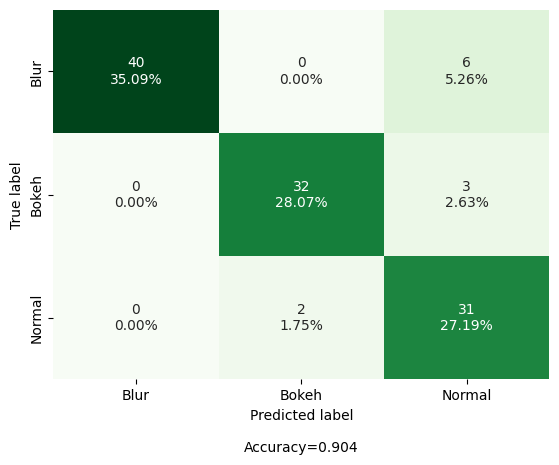

In [ ]:
test_pred = model.predict(X_test)
test_pred = tf.argmax(test_pred, axis=1)
cm = confusion_matrix(y_test, test_pred)
make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)

### Error Analysis

In [ ]:
error_image = X_test[test_pred != y_test]
error_label = tf.cast(y_test[test_pred != y_test],tf.int32)
error_pred = test_pred[test_pred != y_test]

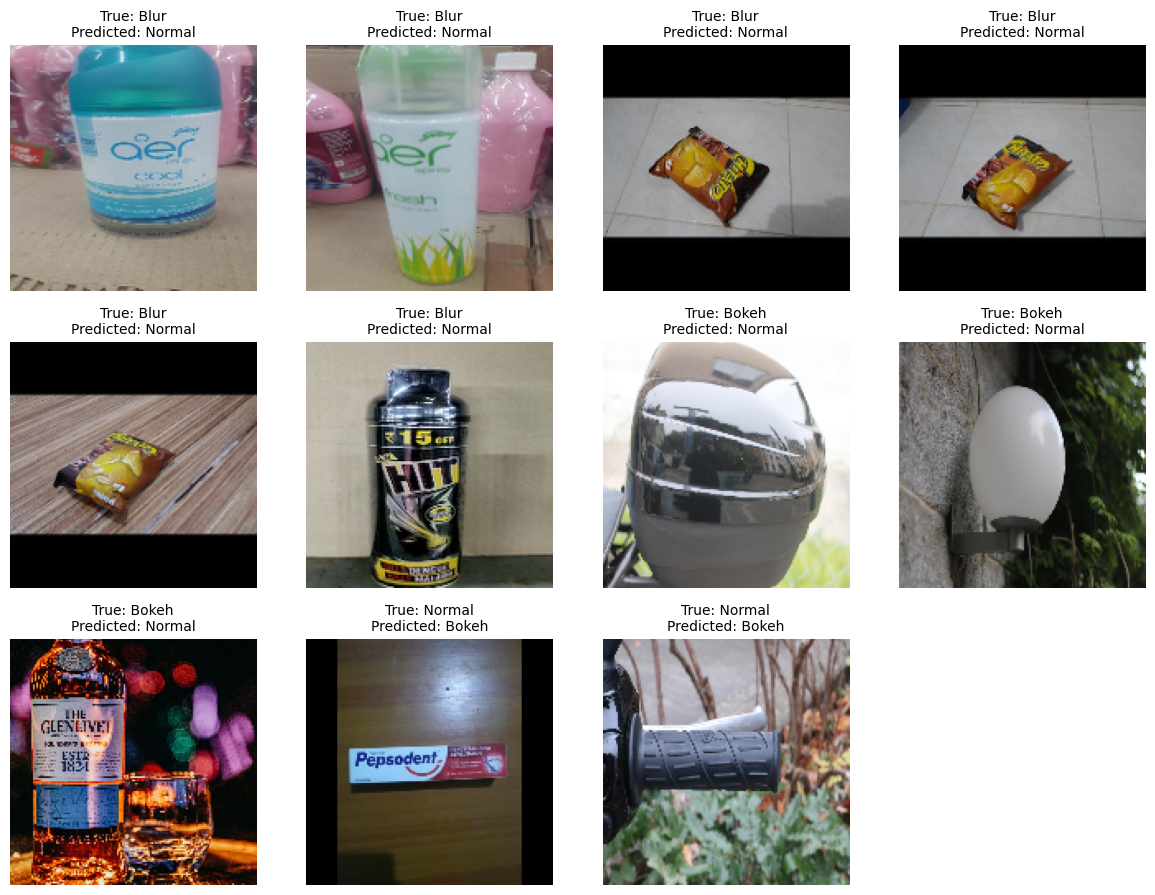

In [ ]:
num_row = 5
num_col = 4
subplot_size = 3
plt.figure(figsize=(num_col*subplot_size, num_row*subplot_size))
for i in range(len(error_image)):
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(error_image[i])
    plt.axis("off")
    plt.title(f"True: {class_names[error_label[i]]}\nPredicted: {class_names[error_pred[i]]}", fontsize=10)
plt.tight_layout()
plt.show()

### Distribution of Variance

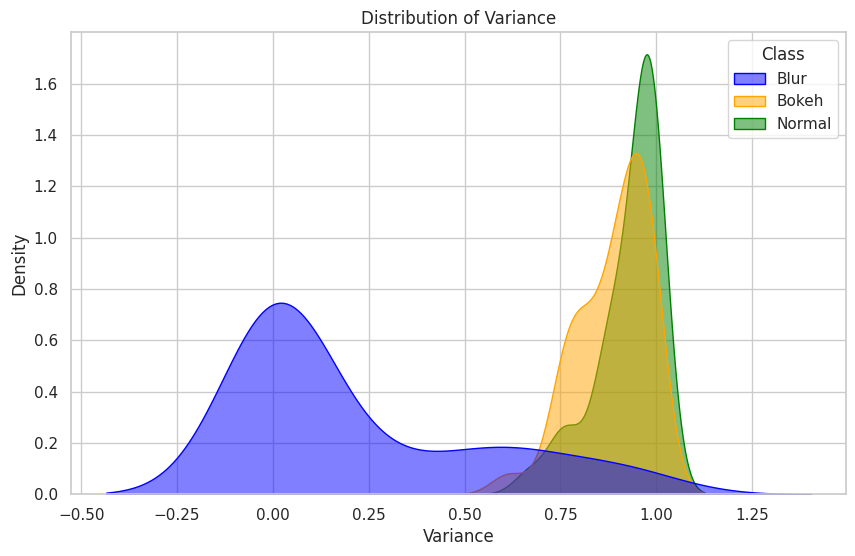

In [ ]:
variance_layer = TransformedVarianceOfLaplacian()
variance = variance_layer(X_test)
labels = y_test

df = pd.DataFrame(np.column_stack([variance, labels]), columns=["Variance", "Class"])
df["Class"] = df["Class"].apply(lambda x: class_names[int(x)])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="Variance", hue="Class", palette=["blue", "orange", "green"], fill=True, alpha=0.5)
plt.title("Distribution of Variance")
plt.xlabel("Variance")
plt.ylabel("Density")
plt.show()

### Model Architecture

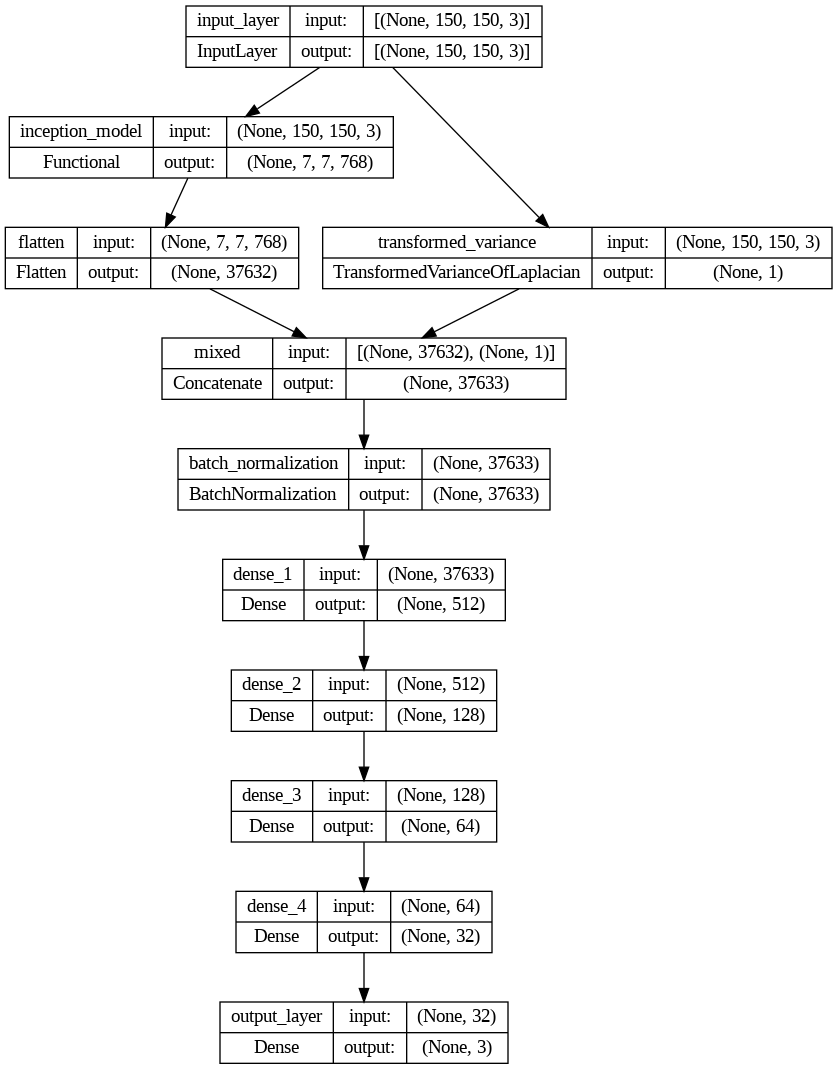

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)